In [66]:
import NetworkArchitectures as nets
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from FCM import FCM
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from dataset_utils import Format_Dataset
from tqdm import tqdm

In [67]:
data_dir = 'data/'
sandbox_dir = data_dir + 'sandbox/'
results_dir = 'results/'
results_sand_dir = results_dir + 'sandbox/sanity2/'

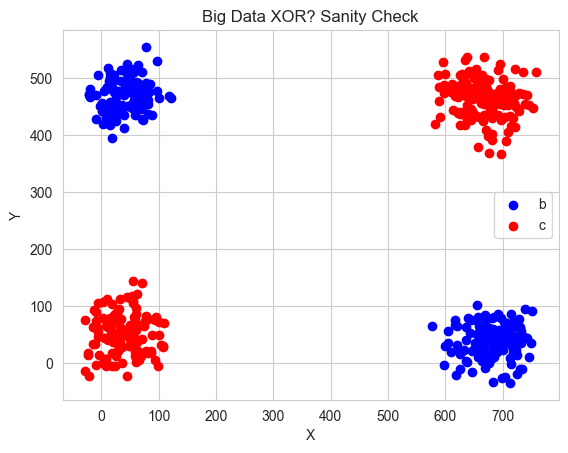

In [68]:
xor = pd.read_csv(sandbox_dir + 'big_data_xor.csv')
xor_grouped = xor.groupby('z')
b = xor_grouped.get_group('b')
c = xor_grouped.get_group('c')

plt.scatter(b['x'], b['y'], color='blue', label='b')
plt.scatter(c['x'], c['y'], color='red', label='c')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Big Data XOR? Sanity Check')
plt.legend()
plt.savefig(results_sand_dir + 'big_data_xor_sanity.png', dpi=900)
plt.show()

In [69]:
encoder = LabelEncoder()
xor['z'] = encoder.fit_transform(xor['z'])

miz_n_xor = xor.sample(frac=1, random_state=42)

split = int(0.8 * len(miz_n_xor))
train = miz_n_xor.iloc[:split]
test = miz_n_xor.iloc[split:]

train_X, train_y = train[['x', 'y']], train['z']
test_X, test_y = test[['x', 'y']], test['z']

train_X, train_y = train_X.to_numpy(), train_y.to_numpy()
test_X, test_y = test_X.to_numpy(), test_y.to_numpy()

s = MinMaxScaler()
train_X = s.fit_transform(train_X)
test_X = s.transform(test_X)

dataset = {
    'samples': train_X,
    'labels': train_y
}
train = Format_Dataset(dataset, choice='Train')
train = torch.utils.data.DataLoader(shuffle=True, dataset=train, batch_size=10)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


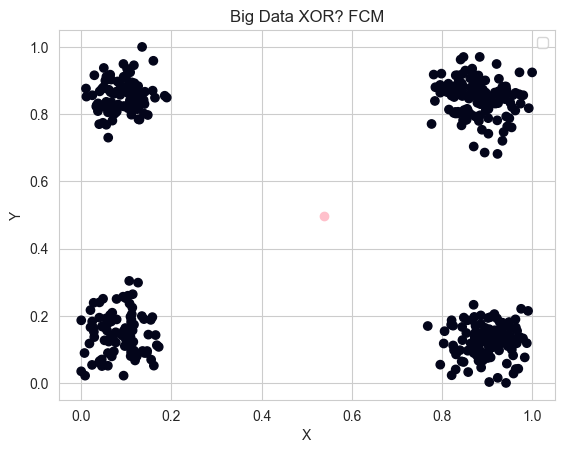

In [70]:
K = 1
fcm = FCM(train_X, K)
centers, membership, fpc = fcm.fit()

plt.scatter(train_X[:, 0], train_X[:, 1], c=membership)
plt.scatter(centers[:, 0], centers[:, 1], color='pink')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Big Data XOR? FCM')
plt.legend()
plt.savefig(results_sand_dir + 'big_data_xor_FCM_c=4.png', dpi=900)
plt.show()

In [71]:
rbf = nets.RBF(k=K, data=train_X, sigma=0.75, mode=2, n_perceptrons=1)

loss_fn = nn.BCELoss()
sgd = optim.Adam(rbf.parameters(), lr=0.01)

list(rbf.parameters())

[Parameter containing:
 tensor([[[0.3539, 0.7342],
          [0.5117, 0.1824]]], dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([[0.5396, 0.4963]], dtype=torch.float64),
 Parameter containing:
 tensor([[-0.5535]], dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([0.0128], dtype=torch.float64, requires_grad=True)]

Training Epochs:  64%|██████▍   | 32/50 [00:01<00:00, 27.09it/s]


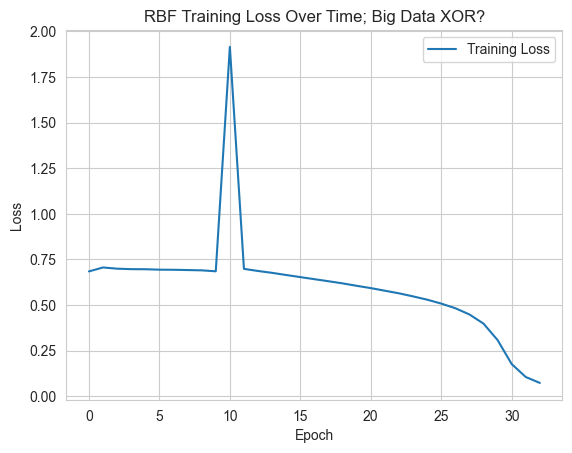

In [72]:
epochs = 50

loss_vals = []
for epoch in tqdm(range(epochs), 'Training Epochs'):
    temp_loss = []
    for samples, labels in train:
        output = rbf(samples)
        loss = loss_fn(output, labels.unsqueeze(0))

        sgd.zero_grad()
        loss.backward()
        sgd.step()

        temp_loss.append(loss.item())

    val = sum(temp_loss[-len(train):]) / len(train)
    loss_vals.append(val)

    if val <= 0.1:
        break

plt.plot(loss_vals, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('RBF Training Loss Over Time; Big Data XOR?')
plt.legend()
plt.savefig(results_sand_dir + 'big_data_xor_RBF_nn_loss.png', dpi=900)
plt.show()

In [73]:
# Let's make some predictions using the trained RBF!
rbf.eval()
with torch.no_grad():
    out = rbf(torch.from_numpy(test_X)).detach().numpy()

preds = []
for i in range(len(out)):
    preds.append(np.round(out[i]))

ps = list(rbf.parameters())
list(rbf.parameters())

[Parameter containing:
 tensor([[[0.4497, 0.6150],
          [0.3132, 0.3362]]], dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([[0.5396, 0.4963]], dtype=torch.float64),
 Parameter containing:
 tensor([[-1.4268]], dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([3.2085], dtype=torch.float64, requires_grad=True)]

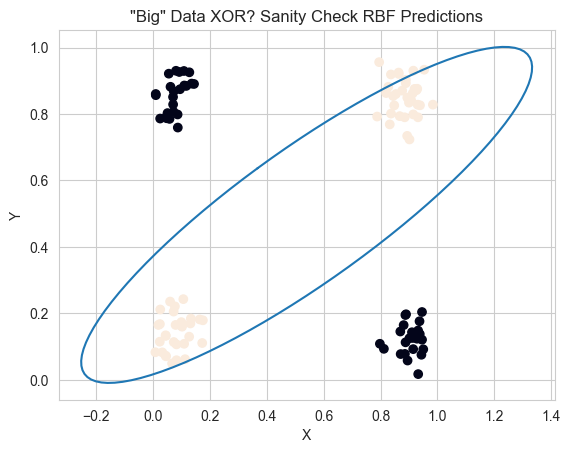

In [74]:
plt.scatter(test_X[:, 0], test_X[:, 1], c=preds)

eigenvalues, eigenvectors = np.linalg.eig(ps[0].detach().numpy()[0])
theta = np.linspace(0, 2*np.pi, 100)
ellipsis = (np.sqrt(np.abs(eigenvalues[None,:])) * eigenvectors) @ [np.sin(theta), np.cos(theta)]
center = ps[1].detach().numpy()
ellipsis = ellipsis + center.reshape(-1, 1)

plt.plot(ellipsis[0,:], ellipsis[1,:])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('"Big" Data XOR? Sanity Check RBF Predictions')
plt.savefig(results_sand_dir + 'big_data_xor_RBF_preds.png', dpi=900)
plt.show()

Accuracy Score: 1.0
Precision Score: 1.0
Recall Score: 1.0
F1 Score:  1.0


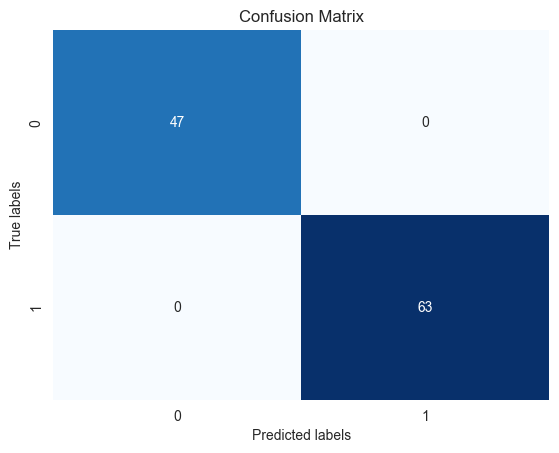

In [75]:
truth = list(test_y)
preds = list(preds[0])

cm = confusion_matrix(truth, preds)

accuracy = accuracy_score(truth, preds)
print("Accuracy Score:", accuracy)

precision = precision_score(truth, preds)
print("Precision Score:", precision)

recall = recall_score(truth, preds)
print("Recall Score:", recall)

f1 = f1_score(truth, preds)
print("F1 Score: ", f1)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig(results_sand_dir + 'XOR_confusion.png', dpi=900)
plt.show()